<a href="https://colab.research.google.com/github/SharveshSp04/CS-4375-Assignments/blob/main/CS4375_A3_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Loading data...
Loaded 500 raw tweets
Step 2: Preprocessing tweets...
After preprocessing: 500 tweets
Step 3: Performing K-means clustering...
Running K-means with K=5...
K=5, SSE=372.39, Cluster sizes: [97, 193, 91, 61, 58]
Running K-means with K=8...
K=8, SSE=370.72, Cluster sizes: [42, 179, 79, 30, 56, 53, 25, 36]
Running K-means with K=10...
K=10, SSE=357.05, Cluster sizes: [157, 12, 29, 36, 17, 50, 68, 26, 68, 37]
Running K-means with K=12...
K=12, SSE=356.86, Cluster sizes: [30, 47, 61, 37, 5, 11, 127, 52, 13, 28, 43, 46]
Running K-means with K=15...
K=15, SSE=346.18, Cluster sizes: [4, 23, 58, 14, 30, 21, 44, 61, 38, 41, 9, 104, 5, 17, 31]

RESULTS TABLE
Value of K   SSE             Size of each cluster          
------------------------------------------------------------
5            372.39          1: 97, 2: 193, 3: 91, 4: 61, 5: 58
8            370.72          1: 42, 2: 179, 3: 79, 4: 30, 5: 56, 6: 53, 7: 25, 8: 36
10           357.05          1: 157, 2: 12, 3: 29, 4

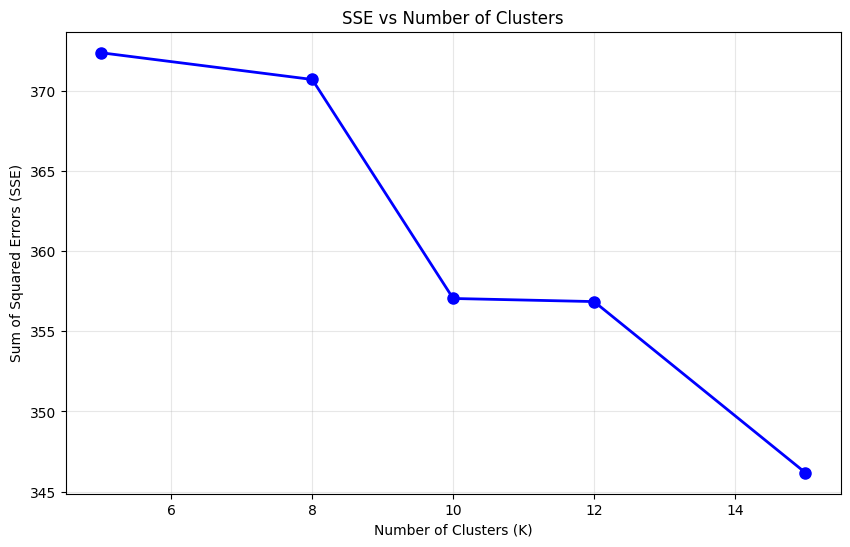


SAMPLE CLUSTERS FOR K=10

Cluster 1 (Size: 157):
Sample tweet words: ['eliminate', 'easy', 'ways', '586189609865994242thu', 'work', 'apr', '0000', 'stress', 'via', '153108']

Cluster 2 (Size: 12):
Sample tweet words: ['amp', 'why', '181026', 'your', 'water', 'will', '2015think', 'fiber', 'unlikely', 'apr']

Cluster 3 (Size: 29):
Sample tweet words: ['bikini', '586160615019909121thu', 'with', 'apr', '0000', '2015getting', 'season', 'ready', 'diet', 'the']


In [3]:
# CS 4375 - Assignment 3 - Part II
# Tweets Clustering using K-means with Jaccard Distance

import numpy as np
import re
import requests
import zipfile
import os
from collections import defaultdict
import random
from typing import List, Set, Tuple, Dict
import matplotlib.pyplot as plt

class TweetProcessor:
    """Class to handle tweet preprocessing"""

    @staticmethod
    def preprocess_tweet(tweet: str) -> Set[str]:
        """
        Preprocess a single tweet by:
        - Removing tweet id and timestamp
        - Removing @mentions
        - Removing hashtag symbols but keeping the word
        - Removing URLs
        - Converting to lowercase
        """
        # Remove tweet id and timestamp (assuming format: id\ttimestamp\ttweet)
        parts = tweet.split('\t')
        if len(parts) >= 3:
            tweet_text = ' '.join(parts[2:])
        else:
            tweet_text = tweet

        # Remove URLs
        tweet_text = re.sub(r'http\S+', '', tweet_text)

        # Remove @mentions
        tweet_text = re.sub(r'@\w+', '', tweet_text)

        # Remove hashtag symbols but keep words
        tweet_text = re.sub(r'#(\w+)', r'\1', tweet_text)

        # Convert to lowercase and split into words
        words = tweet_text.lower().split()

        # Remove empty strings and non-alphanumeric characters
        clean_words = set()
        for word in words:
            # Keep only alphanumeric words with length > 1
            clean_word = re.sub(r'[^a-z0-9]', '', word)
            if len(clean_word) > 1:
                clean_words.add(clean_word)

        return clean_words

class JaccardDistance:
    """Class to compute Jaccard distance between sets"""

    @staticmethod
    def compute_distance(set1: Set[str], set2: Set[str]) -> float:
        """
        Compute Jaccard distance between two sets
        dist = 1 - |A \u2229 B| / |A \u222a B|
        """
        if len(set1) == 0 and len(set2) == 0:
            return 0.0

        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))

        if union == 0:
            return 1.0

        return 1.0 - (intersection / union)

class KMeansClustering:
    """K-means clustering implementation for tweets using Jaccard distance"""

    def __init__(self, k: int, max_iterations: int = 100):
        self.k = k
        self.max_iterations = max_iterations
        self.clusters = []
        self.centroids = []
        self.sse = 0.0

    def _initialize_centroids(self, tweets: List[Set[str]]) -> List[Set[str]]:
        """Initialize centroids using k-means++ initialization"""
        centroids = []

        # Choose first centroid randomly
        centroids.append(random.choice(tweets))

        # Choose remaining centroids using k-means++ method
        for _ in range(1, self.k):
            distances = []
            for tweet in tweets:
                # Find minimum distance to any centroid
                min_dist = min(JaccardDistance.compute_distance(tweet, centroid)
                             for centroid in centroids)
                distances.append(min_dist)

            # Convert distances to probabilities
            total_distance = sum(distances)
            if total_distance > 0:
                probabilities = [d / total_distance for d in distances]
            else:
                probabilities = [1.0 / len(distances)] * len(distances)

            # Choose next centroid based on probabilities
            next_centroid_idx = np.random.choice(len(tweets), p=probabilities)
            centroids.append(tweets[next_centroid_idx])

        return centroids

    def _find_closest_centroid(self, tweet: Set[str]) -> int:
        """Find the index of the closest centroid for a tweet"""
        min_distance = float('inf')
        closest_idx = 0

        for i, centroid in enumerate(self.centroids):
            distance = JaccardDistance.compute_distance(tweet, centroid)
            if distance < min_distance:
                min_distance = distance
                closest_idx = i

        return closest_idx

    def _compute_new_centroids(self) -> List[Set[str]]:
        """Compute new centroids as the tweet with minimum total distance to others in cluster"""
        new_centroids = []

        for cluster in self.clusters:
            if not cluster:
                # If cluster is empty, choose random tweet
                all_tweets = [tweet for cluster in self.clusters for tweet in cluster]
                if all_tweets:
                    new_centroids.append(random.choice(all_tweets))
                else:
                    new_centroids.append(set())
                continue

            # Find the tweet that minimizes total distance to all other tweets in cluster
            min_total_distance = float('inf')
            best_centroid = cluster[0]

            for candidate in cluster:
                total_distance = 0.0
                for tweet in cluster:
                    total_distance += JaccardDistance.compute_distance(candidate, tweet)

                if total_distance < min_total_distance:
                    min_total_distance = total_distance
                    best_centroid = candidate

            new_centroids.append(best_centroid)

        return new_centroids

    def _compute_sse(self) -> float:
        """Compute Sum of Squared Errors"""
        sse = 0.0
        for i, cluster in enumerate(self.clusters):
            for tweet in cluster:
                distance = JaccardDistance.compute_distance(tweet, self.centroids[i])
                sse += distance ** 2
        return sse

    def fit(self, tweets: List[Set[str]]) -> Tuple[List[List[Set[str]]], float]:
        """Perform K-means clustering on tweets"""
        # Initialize centroids
        self.centroids = self._initialize_centroids(tweets)

        for iteration in range(self.max_iterations):
            # Assign tweets to clusters
            self.clusters = [[] for _ in range(self.k)]

            for tweet in tweets:
                cluster_idx = self._find_closest_centroid(tweet)
                self.clusters[cluster_idx].append(tweet)

            # Compute new centroids
            new_centroids = self._compute_new_centroids()

            # Check for convergence
            if new_centroids == self.centroids:
                break

            self.centroids = new_centroids

        # Compute final SSE
        self.sse = self._compute_sse()

        return self.clusters, self.sse

    def get_cluster_sizes(self) -> List[int]:
        """Get sizes of each cluster"""
        return [len(cluster) for cluster in self.clusters]

class DataLoader:
    """Class to load and process tweet data"""

    @staticmethod
    def download_and_extract_data():
        """Download and extract the health news tweets dataset"""
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00438/Health-News-Tweets.zip"
        local_zip_path = "Health-News-Tweets.zip"
        extract_path = "Health-News-Tweets"

        # Download if not exists
        if not os.path.exists(local_zip_path):
            print("Downloading dataset...")
            response = requests.get(url)
            with open(local_zip_path, 'wb') as f:
                f.write(response.content)

        # Extract if not exists
        if not os.path.exists(extract_path):
            print("Extracting dataset...")
            with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)

        return extract_path

    @staticmethod
    def load_tweets_from_file(file_path: str, max_tweets: int = 1000) -> List[str]:
        """Load tweets from a specific file"""
        tweets = []
        try:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                for line in f:
                    if len(tweets) >= max_tweets:
                        break
                    if line.strip():
                        tweets.append(line.strip())
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")

        return tweets

def main():
    """Main function to run the tweet clustering analysis"""

    # Step 1: Download and load data
    print("Step 1: Loading data...")
    data_loader = DataLoader()
    data_path = data_loader.download_and_extract_data()

    # Choose a specific file (e.g., usnewshealth.txt)
    tweet_file = os.path.join(data_path, "Health-Tweets", "usnewshealth.txt")

    # Load raw tweets
    raw_tweets = data_loader.load_tweets_from_file(tweet_file, max_tweets=500)
    print(f"Loaded {len(raw_tweets)} raw tweets")

    # Step 2: Preprocess tweets
    print("Step 2: Preprocessing tweets...")
    processor = TweetProcessor()
    processed_tweets = [processor.preprocess_tweet(tweet) for tweet in raw_tweets]

    # Remove empty tweets
    processed_tweets = [tweet for tweet in processed_tweets if len(tweet) > 0]
    print(f"After preprocessing: {len(processed_tweets)} tweets")

    # Step 3: Perform K-means clustering for different values of K
    print("Step 3: Performing K-means clustering...")

    k_values = [5, 8, 10, 12, 15]
    results = []

    for k in k_values:
        print(f"Running K-means with K={k}...")

        # Initialize and run K-means
        kmeans = KMeansClustering(k=k, max_iterations=50)
        clusters, sse = kmeans.fit(processed_tweets)
        cluster_sizes = kmeans.get_cluster_sizes()

        results.append({
            'k': k,
            'sse': sse,
            'cluster_sizes': cluster_sizes,
            'clusters': clusters
        })

        print(f"K={k}, SSE={sse:.2f}, Cluster sizes: {cluster_sizes}")

    # Step 4: Display results in table format
    print("\n" + "="*60)
    print("RESULTS TABLE")
    print("="*60)
    print(f"{'Value of K':<12} {'SSE':<15} {'Size of each cluster':<30}")
    print("-"*60)

    for result in results:
        k = result['k']
        sse = result['sse']
        cluster_sizes = result['cluster_sizes']

        # Format cluster sizes as string
        size_str = ", ".join([f"{i+1}: {size}" for i, size in enumerate(cluster_sizes)])

        print(f"{k:<12} {sse:<15.2f} {size_str:<30}")

    # Step 5: Plot SSE vs K
    plt.figure(figsize=(10, 6))
    k_list = [result['k'] for result in results]
    sse_list = [result['sse'] for result in results]

    plt.plot(k_list, sse_list, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.title('SSE vs Number of Clusters')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Step 6: Display sample clusters for K=10
    print("\n" + "="*60)
    print("SAMPLE CLUSTERS FOR K=10")
    print("="*60)

    k10_result = next(result for result in results if result['k'] == 10)
    clusters = k10_result['clusters']

    for i, cluster in enumerate(clusters[:3]):  # Show first 3 clusters
        if cluster:
            print(f"\nCluster {i+1} (Size: {len(cluster)}):")
            sample_tweet_words = list(cluster[0])[:10]  # Show first 10 words of first tweet
            print(f"Sample tweet words: {sample_tweet_words}")

if __name__ == "__main__":
    main()
